<a href="https://colab.research.google.com/github/lisaong/diec/blob/master/day3/pyswarms_v_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
!pip install pyswarms

In [0]:
import tensorflow as tf
import pyswarms as ps

In [0]:
# load dataset
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

In [0]:
# scale to enable convergence
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255

In [0]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(512, input_shape=(X_train_flat.shape[1],), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import TensorBoard

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs2

Reusing TensorBoard on port 6006 (pid 207), started 0:11:11 ago. (Use '!kill 207' to kill it.)

In [12]:
import datetime as datetime
import os
logdir = os.path.join('logs2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=logdir)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

N = 1000

# batch_size 1 to simplify pyswarm comparison
model.fit(X_train_flat[:N], y_train_cat[:N], batch_size=1, epochs=5,
          callbacks=[tb])

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.8572 - accuracy: 0.7400
Epoch 2/5
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.4270 - accuracy: 0.8940
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.2914 - accuracy: 0.9330
Epoch 4/5
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.1852 - accuracy: 0.9560
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.1205 - accuracy: 0.9770


In [13]:
# pyswarm
# https://pyswarms.readthedocs.io/en/latest/examples/usecases/train_neural_network.html
#
# Neural network architecture
# =================================================================
# dense_3 (Dense)              (None, 512)               401920    
# _________________________________________________________________
# dense_4 (Dense)              (None, 128)               65664     
# _________________________________________________________________
# dense_5 (Dense)              (None, 10)                1290      
# =================================================================

n_inputs = 784 # W1: 784 x 512, b1: 512
n_hidden1 = 512 # W2: 512 x 128, b2: 128
n_hidden2 = 128 # W3: 128 x 10, b3: 10
n_classes = 10

chunks = [
  n_inputs*n_hidden1,
  n_hidden1,
  n_hidden1*n_hidden2,
  n_hidden2,
  n_hidden2*n_classes,
  n_classes
]

import numpy as np
dimensions = np.sum(np.array(chunks))
print(dimensions)

468874


In [0]:
def stable_softmax(x):
    z = x - np.max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    return numerator/denominator

def cross_entropy(targets, predictions, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: targets (N, k) ndarray
           predictions (N, k) ndarray
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

def relu(x):
  return np.maximum(x, 0)

def forward(params, X):
    # Roll-back the weights and biases (can probably be a loop)
    offset = 0
    W1 = params[offset:offset+chunks[0]].reshape((n_inputs, n_hidden1))
    offset = offset + chunks[0]
    b1 = params[offset:offset+chunks[1]].reshape((n_hidden1,))
    offset = offset + chunks[1]
    W2 = params[offset:offset+chunks[2]].reshape((n_hidden1, n_hidden2))
    offset = offset + chunks[2]
    b2 = params[offset:offset+chunks[3]].reshape((n_hidden2,))
    offset = offset + chunks[3]
    W3 = params[offset:offset+chunks[4]].reshape((n_hidden2, n_classes))
    offset = offset + chunks[4]
    b3 = params[offset:offset+chunks[5]].reshape((n_classes,))

    z1 = X.dot(W1) + b1   # Pre-activation in Layer 1
    a1 = relu(z1)         # Activation in Layer 1
    z2 = a1.dot(W2) + b2  # Pre-activation in Layer 2
    a2 = relu(z2)         # Activation in Layer 2
    z3 = a2.dot(W3) + b3  # Pre-activation in Layer 3
    logits = z3           # Logits for Layer 3
    return logits

def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss. It receives a set of parameters that must be
    rolled-back into the corresponding weights and biases.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """
    # Perform forward propagation
    X = X_train_flat[:N]
    y = y_train_cat[:N]

    logits = forward(params, X)

    # Compute for the softmax of the logits
    #exp_scores = np.exp(logits)
    #probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    probs = stable_softmax(logits)

    # Compute for the negative log likelihood
    #correct_logprobs = -np.log(probs[range(N), y])
    #loss = np.sum(correct_logprobs) / N
    loss = cross_entropy(y, probs)
    return loss

def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

def predict(X, pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    X: numpy.ndarray
        Input dataset
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """
    logits = forward(pos, X)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [15]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=dimensions, 
                                    options=options)

# Perform optimization
# This is highly memory intensive, need to tune n_particles and iters
cost, pos = optimizer.optimize(f, iters=10)

2019-12-11 09:18:01,926 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=9.38
2019-12-11 09:18:25,007 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.37803002717632, best pos: [-0.33347772  0.28318435 -1.12919492 ... -0.34419364 -0.10721248
 -0.14673526]


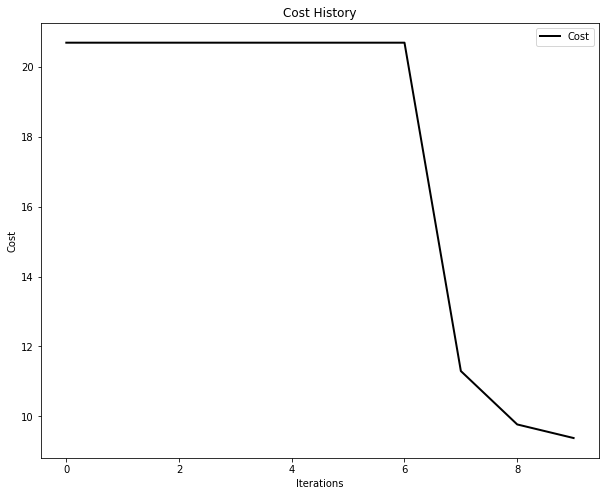

In [16]:
from pyswarms.utils.plotters import plot_cost_history
import matplotlib.pyplot as plt

# Obtain cost history from optimizer instance
cost_history = optimizer.cost_history

plot_cost_history(cost_history)
plt.show()

In [26]:
# accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, 
               predict(X_test_flat, pos))

0.1119